In [1]:
import os
import sys

import tensorflow as tf
from tensorflow import keras

from modules import utils as utils

# from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import scipy.stats

# import requests
import matplotlib.pyplot as plt

# plt.style.use("seaborn-darkgrid")
import csv
import pandas as pd
import json

import argparse
from pathlib import Path


# import computer vision functions
import cv2
from skimage.util import img_as_ubyte
from modules.cv import scale_pixel_values as scale_pixel_values
from modules.cv import filter_gauss_images as filter_gauss_images
from modules.cv import filter_median_images as filter_median_images
from modules.cv import threshold_images as threshold_images
from modules.cv import label_images as label_images

from modules.resmaps import calculate_resmaps
import skimage

Using TensorFlow backend.


#### import validation and test inputs and reconstructions

In [2]:
imgs_val_input = np.load("saved_models/mvtec/capsule/mvtec2/SSIM/19-04-2020_14-14-36/inspection_val/imgs_val_input.npy", allow_pickle=True)
imgs_val_pred = np.load("saved_models/mvtec/capsule/mvtec2/SSIM/19-04-2020_14-14-36/inspection_val/imgs_val_pred.npy", allow_pickle=True)

imgs_test_input = np.load("saved_models/mvtec/capsule/mvtec2/SSIM/19-04-2020_14-14-36/inspection_test/imgs_test_input.npy", allow_pickle=True)
imgs_test_pred = np.load("saved_models/mvtec/capsule/mvtec2/SSIM/19-04-2020_14-14-36/inspection_test/imgs_test_pred.npy", allow_pickle=True)

#### compute validation resmaps in different ways

In [3]:
# compute resmaps by substracting pred out of input
resmaps_val_diff = imgs_val_input - imgs_val_pred
# compute resmaps using the ssim method
resmaps_val_ssim = calculate_resmaps(imgs_val_input, imgs_val_pred, method="SSIM")
# compute resmaps using the L2 method
resmaps_val_l2 = calculate_resmaps(imgs_val_input, imgs_val_pred, method="L2")

#### compute test resmaps in different ways

In [4]:
# compute resmaps by substracting pred out of input
resmaps_test_diff = imgs_test_input - imgs_test_pred
# compute resmaps using the ssim method
resmaps_test_ssim = calculate_resmaps(imgs_test_input, imgs_test_pred, method="SSIM")
# compute resmaps using the L2 method
resmaps_test_l2 = calculate_resmaps(imgs_test_input, imgs_test_pred, method="L2")

### Visualize Image Histograms

In [5]:
def hist_image(img, bins=400, range_x=[-1,1], plot_gauss=True, title=None):
    # plot histogram
    plt.style.use("seaborn-darkgrid")
    img_1d = img.flatten()
    plt.figure()
    plt.hist(img_1d, bins=bins, range=range_x, density=True, stacked=True, label="image histogram")
    
    # print descriptive values
    mu = img_1d.mean()
    sigma = img_1d.std()
    minimum = np.amin(img_1d)
    maximum = np.amax(img_1d)
    print("{} \n mu = {} \n sigma = {} \n min = {}\n max = {}".format(title, mu, sigma, minimum, maximum))
    
    if plot_gauss:
        # compute and plot probability distribution function    
        X = np.linspace(start=minimum, stop=maximum, num=200, endpoint=True)
        pdf_x = [scipy.stats.norm(mu, sigma).pdf(x) for x in X]
        plt.plot(X, pdf_x, label="pixel distribution")
        plt.title(title)
    
    if range_x is not None:
        plt.xlim(range_x[0], range_x[1])
    plt.legend()
    plt.show()

#### Inspecting Validation and Test Histograms and data range

In [6]:
imgs_val_input.dtype

dtype('float32')

In [7]:
resmaps_val_diff.dtype

dtype('float32')

None 
 mu = -0.05801284313201904 
 sigma = 0.031799957156181335 
 min = -0.36593306064605713
 max = 0.3517126739025116


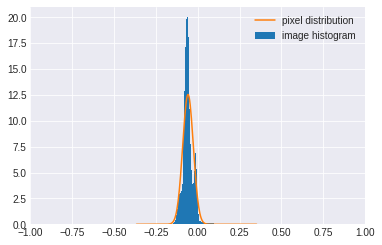

In [8]:
hist_image(resmaps_val_diff, range_x=[-1,1])

None 
 mu = -0.053750693798065186 
 sigma = 0.036169104278087616 
 min = -0.623037576675415
 max = 0.7707493901252747


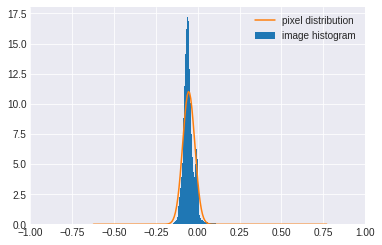

In [9]:
hist_image(resmaps_test_diff, range_x=[-1,1])

None 
 mu = 0.0043767280876636505 
 sigma = 0.0037513701245188713 
 min = 4.9960036108132044e-14
 max = 0.1339070051908493


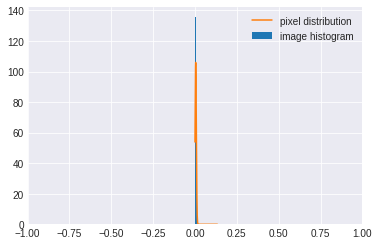

In [10]:
hist_image(resmaps_val_l2, range_x=[-1,1])

None 
 mu = 0.035270480178012056 
 sigma = 0.06358052510564811 
 min = 0.0014516243292440612
 max = 1.0


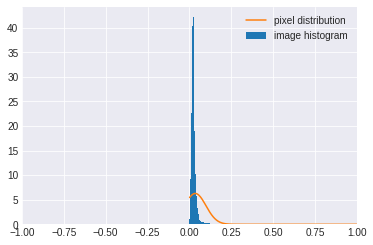

In [11]:
hist_image(resmaps_val_ssim, range_x=[-1,1])

None 
 mu = 0.037864892889847124 
 sigma = 0.07560001306768648 
 min = 0.0006165190299610712
 max = 1.0


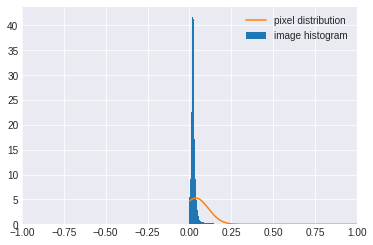

In [12]:
hist_image(resmaps_test_ssim, range_x=[-1,1])

# Investigating different Image dtypes

In [13]:
from skimage.util import img_as_ubyte
from skimage.util import img_as_uint

In [18]:
def hist_image_uint(img, range_x=None, plot_gauss=True, title=None):
    # plot histogram    
    plt.style.use("seaborn-darkgrid")
    plt.figure()
    # compute bin edges
    img_1d = img.flatten()
    d = np.diff(np.unique(img_1d)).min()
    left_of_first_bin = img_1d.min() - float(d)/2
    right_of_last_bin = img_1d.max() + float(d)/2  
    bins = np.arange(left_of_first_bin, right_of_last_bin + d, d)
    plt.hist(img_1d, bins=bins, density=True, stacked=True, label="pixel value histogram")
    
    # print descriptive values
    mu = img_1d.mean()
    sigma = img_1d.std()
    minimum = np.amin(img_1d)
    maximum = np.amax(img_1d)
    print("{} \n mu = {} \n sigma = {} \n min = {}\n max = {}".format(title, mu, sigma, minimum, maximum))
    
    if plot_gauss:
        # compute and plot probability distribution function    
        X = np.linspace(start=minimum, stop=maximum, num=200, endpoint=True)
        pdf_x = [scipy.stats.norm(mu, sigma).pdf(x) for x in X]
        plt.plot(X, pdf_x, label="pixel distribution")
        plt.title(title)
    
    if range_x is not None:
        plt.xlim(range_x[0], range_x[1])
    
    plt.legend()
    plt.show()
    
    return bins

In [19]:
resmaps_val_uint8 = img_as_ubyte(resmaps_val_ssim.copy())
resmaps_test_uint8 = img_as_ubyte(resmaps_test_ssim.copy())

resmaps_val_uint16 = img_as_uint(resmaps_val_ssim.copy())
resmaps_test_uint16 = img_as_uint(resmaps_test_ssim.copy())

None 
 mu = 8.99417477562314 
 sigma = 16.21563167789358 
 min = 0
 max = 255


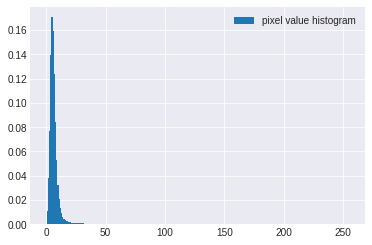

In [20]:
bins_val_uint8 = hist_image_uint(resmaps_val_uint8, plot_gauss=False)

In [28]:
bins_val_uint8[:10]

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5])

In [22]:
np.diff(np.unique(bins_val_uint8)).min()

1.0

None 
 mu = 2311.4512648809523 
 sigma = 4166.749652607837 
 min = 95
 max = 65535


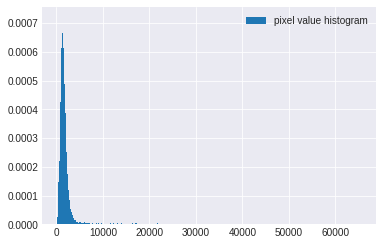

In [23]:
bins_val_uint16 = hist_image_uint(resmaps_val_uint16, plot_gauss=False)

In [24]:
np.diff(np.unique(bins_val_uint16)).min()

1.0

In [25]:
bins_val_uint16[:10]

array([ 94.5,  95.5,  96.5,  97.5,  98.5,  99.5, 100.5, 101.5, 102.5,
       103.5])

In [26]:
np.amax(bins_val_uint16)

65535.5

In [27]:
np.amin(bins_val_uint16)

94.5

None 
 mu = 9.65642397331469 
 sigma = 19.27968216346663 
 min = 0
 max = 255


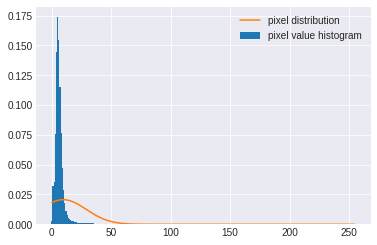

In [59]:
bins_test_uint8 = hist_image_uint(resmaps_test_uint8, plot_gauss=False)

In [ ]:
bins_test_uint16 = hist_image_uint(resmaps_test_uint16, plot_gauss=False)

In [ ]:
bins_test_uint16